In [1]:
from math import comb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import os
import pandas as pd

import sys
sys.path.append("../../swag_modified/swag")
from utils import compute_outer_fence_mean_standard_deviation

In [2]:
pwd

'/home/armstrong/Research/git_repos/patprob/no_duplicates/p_ensemble'

In [2]:
figdir="./figures_median_ensemble_IFtrimmed"
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
data_path = "../uuss_data/p_resampled"

In [3]:
def load_model_results(file_name):
    file = np.load(file_name)
    predictions = file["predictions"]
    targets = file["targets"][:, 0]

    return predictions, targets

In [4]:
model1_file = "seed1_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_test_fewerhist_uncertainty_60.npz"
model2_file = "seed2_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_test_fewerhist_uncertainty_60.npz"
model3_file = "seed3_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_test_fewerhist_uncertainty_60.npz"

model1_preds, model1_targets = load_model_results(model1_file)
model2_preds, model2_targets = load_model_results(model2_file)
model3_preds, model3_targets = load_model_results(model3_file)

In [5]:
combined_predictions = np.concatenate([model1_preds, model2_preds, model3_preds], axis=1)
assert np.array_equal(model1_targets, model2_targets)
assert np.array_equal(model1_targets, model3_targets)

In [6]:
q1, q3  = np.percentile(combined_predictions, [25,75], axis=1)
iqr = q3 - q1
if1 = q1 - 1.5*iqr
if3 = q3 + 1.5*iqr
trimmed_std = np.zeros(combined_predictions.shape[0])
trimmed_predictions = []
trimmed_median = np.zeros(combined_predictions.shape[0])
for i in range(len(combined_predictions)):
    trimmed = combined_predictions[i][np.where(np.logical_and(combined_predictions[i] > if1[i], combined_predictions[i] < if3[i]))]
    trimmed_std[i] = np.std(trimmed)
    trimmed_predictions.append(trimmed)
    trimmed_median[i] = np.median(trimmed)
trimmed_residuals = model1_targets - trimmed_median

In [7]:
trimmed_residuals = model1_targets - trimmed_median

va 0.0899567553600984
swa_va nan
va 0.08965471105303968
swa_va nan
va 0.08921266310816105
swa_va nan


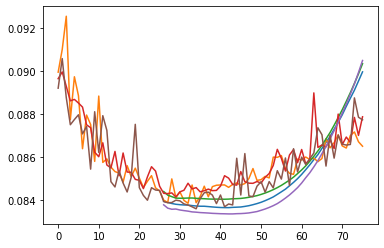

In [8]:
for seed in [1, 2, 3]:
    filename = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20/train_metrics.csv"
    df = pd.read_csv(filename)
    plt.plot(np.arange(len(df)), df.swa_va_rms)
    plt.plot(np.arange(len(df)), df.va_rms)
    print("va", df.va_rms[0])
    print("swa_va", df.swa_va_rms[0])

In [9]:
# Not trimmed
model1_resids = (model1_targets - np.median(model1_preds, axis=1))
model2_resids = (model2_targets - np.median(model2_preds, axis=1))
model3_resids = (model3_targets - np.median(model3_preds, axis=1))

print("seed 1", compute_outer_fence_mean_standard_deviation(model1_resids), 
     np.sqrt(np.sum(model1_resids**2)/len(model1_resids)))
print("seed 2", compute_outer_fence_mean_standard_deviation(model2_resids), 
     np.sqrt(np.sum(model2_resids**2)/len(model2_resids)))
print("seed 3", compute_outer_fence_mean_standard_deviation(model3_resids), 
     np.sqrt(np.sum(model3_resids**2)/len(model3_resids)))

seed 1 (0.004817041620435789, 0.05167655960595085) 0.08836154610366627
seed 2 (0.004616895310027845, 0.051674041063713004) 0.08890399936482025
seed 3 (0.005389459447283768, 0.05150743519613902) 0.08889453264066081


(0.004902175443572902, 0.05024129441102332)


Text(0.5, 0, 'Seconds')

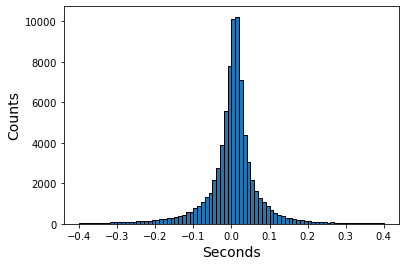

In [10]:
# Without trimming
predictions_median = np.median(combined_predictions, axis=1)
print(compute_outer_fence_mean_standard_deviation((model1_targets - predictions_median)))
plt.hist((model1_targets - predictions_median), bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k" );
plt.ylabel("Counts", fontsize=14)
plt.xlabel("Seconds", fontsize=14)

In [11]:
np.sqrt(np.sum((model1_targets - predictions_median)**2)/len((model1_targets - predictions_median)))

0.08773890623716825

In [12]:
pwd

'/home/armstrong/Research/git_repos/patprob/no_duplicates/p_ensemble'

(0.004744525119085781, 0.05030099385725349)


Text(0.5, 0, 'Seconds')

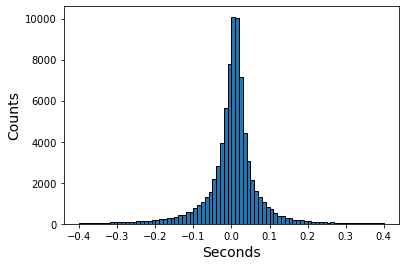

In [13]:
# with trimming
print(compute_outer_fence_mean_standard_deviation((trimmed_residuals)))
plt.hist((trimmed_residuals), bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k" );
plt.ylabel("Counts", fontsize=14)
plt.xlabel("Seconds", fontsize=14)

In [14]:
np.sqrt(np.sum(trimmed_residuals**2)/len(trimmed_residuals))

0.08772328660518904

In [15]:
print(np.min(trimmed_residuals))
print(np.max(trimmed_residuals))

-0.8479629755020142
0.8480645567178726


In [16]:
import h5py
f = h5py.File(f"{data_path}/uuss_test_fewerhist_4s_1dup.h5", "r")
X = f["X"][:]
Y = f["Y"][:]
f.close()


import pandas as pd
meta_df = pd.read_csv(f"{data_path}/uuss_test_fewerhist.csv")

In [17]:
wf_len = X.shape[1]
wf_center = wf_len//2

In [18]:
from joblib import load
s_cal = load('p_calibration_model_medians_ensemble_IFtrimmed.joblib')

lb = 0.05
ub = 0.95

# Transform the lower and upper bounds to be calibrated
lb_transform = s_cal.transform([lb])[0]
ub_transform = s_cal.transform([ub])[0]

# Compute the lower and upper bounds for each prediction given the mean and std
# test_df["lb_y"] = test_df.apply(lambda x: norm.ppf(lb_transform, x["y_pred"], x["std"]), axis=1)
# test_df["ub_y"] = test_df.apply(lambda x: norm.ppf(ub_transform, x["y_pred"], x["std"]), axis=1)

In [19]:
print( s_cal.transform([0.16])[0])
print( s_cal.transform([0.84])[0])
print( s_cal.transform([0.05])[0])
print( s_cal.transform([0.95])[0])

0.07066940318143151
0.9559536145895293
0.00015533004473285584
0.9993986137980173


In [20]:
# combined_df = pd.DataFrame([combined_means, combined_stds]).transpose()
combined_df = pd.DataFrame([trimmed_median, trimmed_std]).transpose()
combined_df.columns = ["y_pred", "std"]
combined_df.head()

,y_pred,std
0,0.293970,0.017291
1,0.192086,0.011145
2,0.427116,0.024660
3,0.475283,0.034338
4,0.134654,0.019223


In [21]:
from scipy.stats import norm 
combined_df["lb_y"] = combined_df.apply(lambda x: norm.ppf(lb_transform, x["y_pred"], x["std"]), axis=1)
combined_df["ub_y"] = combined_df.apply(lambda x: norm.ppf(ub_transform, x["y_pred"], x["std"]), axis=1)

In [22]:
combined_df.loc[:, "y_act"] = model1_targets

In [23]:
combined_df.head()

,y_pred,std,lb_y,ub_y,y_act
0,0.293970,0.017291,0.231616,0.349961,0.32
1,0.192086,0.011145,0.151894,0.228177,0.20
2,0.427116,0.024660,0.338185,0.506971,0.43
3,0.475283,0.034338,0.351453,0.586476,0.45
4,0.134654,0.019223,0.065330,0.196903,0.18


In [24]:
combined_df.to_csv("calibrated_CI_test_fewerhist_N40.csv", index=False)

In [42]:
quality_map = {1.0:0, 0.75:1, 0.5:2}
for i in range(0, 100):
    shift = model1_targets[i]
    shifted_predictions = trimmed_predictions[i]-shift
#     shifted_m1_preds = model1_preds[i, :][np.where(np.logical_and(model1_preds[i, :] > if1[i], model1_preds[i, :] < if3[i]))] - shift
#     shifted_m2_preds = model2_preds[i, :][np.where(np.logical_and(model2_preds[i, :] > if1[i], model2_preds[i, :] < if3[i]))] - shift
#     shifted_m3_preds = model3_preds[i, :][np.where(np.logical_and(model3_preds[i, :] > if1[i], model3_preds[i, :] < if3[i]))] - shift
    shifted_m1_preds = model1_preds[i, :] - shift
    shifted_m2_preds = model2_preds[i, :] - shift
    shifted_m3_preds = model3_preds[i, :] - shift
    #print(shifted_m1_preds.shape)
    #shifted_pick = combined_means[i]-shift
    shifted_pick = trimmed_median[i] - shift
    #print(model1_targets[i], predictions_median[i], model1_targets[i]-predictions_median[i], shifted_pick)

    std = trimmed_std[i]
    quality = quality_map[meta_df.iloc[i].pick_quality]
    fig, ax = plt.subplots(1)
        
    ## Horizontal line at 0
    ax.axhline(0, alpha=0.2, color="k")

    lb_y = combined_df.iloc[i]["lb_y"] - shift
    ub_y = combined_df.iloc[i]["ub_y"] - shift

    #width = round(np.max([np.max(abs(shifted_predictions)) + 0.1, abs(lb_y), abs(ub_y)]), 2)
    width = round(np.max([np.max(abs(shifted_m1_preds)) + 0.1,
                      np.max(abs(shifted_m2_preds)) + 0.1,
                      np.max(abs(shifted_m3_preds)) + 0.1, abs(lb_y), abs(ub_y)]), 2)

    ## Prediction histogram
    #bins = ax.hist(shifted_predictions, bins=30, density=True, alpha=0.7)
    #bins = np.arange(round(np.min(shifted_predictions)-0.02, 2), round(np.max(shifted_predictions)+0.02, 2), 0.01)
    bins = np.arange(round(-1*width, 2), round(width, 2), 0.01)

    bins = ax.hist([shifted_m1_preds, shifted_m2_preds, shifted_m3_preds], bins=bins, stacked=True, density = True, 
                   alpha=1.0, edgecolor="black", linewidth=0.7, label=["m1", "m2", "m3"], 
                   color=["#5ab4ac", "#c7eae5", "#01665e"])
                   #color=["#ffffcc", "#2c7fb8", "#41b6c4"])
                   #color=["#EA5F94", "#FA8775", "#FFB14E"])
                   #color=["#D81B60", "#1E88E5", "#FFC107"])
    

    
    ## Trim and scale waveform
    max_dens = np.max(bins[0])
    #     width = round(np.max(abs(shifted_predictions)) + 0.1, 2)
    #width = round(np.max([np.max(abs(shifted_predictions)) + 0.1, abs(lb_y), abs(ub_y)]), 2)

    wf_width = round(width*100)
    wf_width = round(width*100)
    pick_loc = wf_center + int(Y[i]*100)
    wf = (X[i, pick_loc-wf_width:pick_loc+wf_width+1])
    # wf_norm = np.array(max_dens)/np.max(abs(wf), axis=0)
    wf_norm = max_dens/np.max(abs(wf))

    ## Plot waveform
    x_vals = np.arange(-width, round(width+0.01, 2), 0.01)
    ax.plot(x_vals[:len(wf)], wf*wf_norm, color="dimgray", label="Z")
#     ax.plot(x_vals[:len(wf)], wf[:, 1]*wf_norm[1], color="slategray", label="N")
#     ax.plot(x_vals[:len(wf)], wf[:, 2]*wf_norm[2], color="darkgray", label="Z")

    ## Plot gaussion over predictions

#     hist_range = np.zeros(len(bins[1])+2)
#     hist_range[0] = bins[1][0] - 0.01
#     hist_range[-1] = bins[1][-1] + 0.01
#     hist_range[1:-1] = bins[1]
    #ax.plot(hist_range, norm.pdf(hist_range, shifted_pick, std), color="r")
    #ax.axvline(shifted_pick - std, linestyle=(5, (10, 3)), ymin=0.5, color="k", label="1 std")
    #ax.axvline(shifted_pick + std, linestyle=(5, (10, 3)), color="k")
    
    ## Plot calibrated upper and lower bounds
    ax.axvline(lb_y, color="k", linestyle="--", linewidth=2)
    ax.axvline(ub_y, color="k", linestyle="--", linewidth=2, label="C. I.")
    
    ## Only plot positive density ticks
    ax.set_yticks(np.arange(0, max_dens+10, 10))
    
    ## Plot STD and Pick Quality Information
    ax.text(0.025, 0.75, f"Analyst Quality: {quality}\nSTD: {str(round(std, 3))}\nC. I.: {str(round(ub_y-lb_y, 3))}", transform=ax.transAxes, fontsize=12, 
           bbox=dict(facecolor='white', alpha=0.9, edgecolor="lightgrey", boxstyle="round"))
    
    ## Set X & Y labels
    ax.set_ylabel("Density", fontsize=14)
    ax.set_xlabel("Seconds", fontsize=14)
    
    ## Only plot STD lines for positive density
    ylim = ax.get_ylim()
#     ax.vlines(shifted_pick - std, ymin=ylim[0], ymax=ylim[1], linestyle="--", label="1 std", 
#               linewidth=2.5, color="#d8b365") #color="#f6e8c3")
#     ax.vlines(shifted_pick + std, ymin=ylim[0], ymax=ylim[1], linestyle="--", linewidth=2.5, color="#d8b365") # color="#f6e8c3")
    
    ax.axvline(shifted_pick - std, linestyle="--", label="1 std", linewidth=2.5, color="#d8b365") #color="#f6e8c3")
    ax.axvline(shifted_pick + std, linestyle="--", linewidth=2.5, color="#d8b365") # color="#f6e8c3")
   
    ax.axvline(if1[i]-shift, color="purple")
    ax.axvline(if3[i]-shift, color="purple")
               
    ax.set_ylim([np.min([ylim[0], -0.75*ylim[1]]), ylim[1]])
    
    ## Plot picks
    ax.axvline(shifted_pick, label="y_pred", linewidth=2, color="#d8b365")
    ax.axvline(0, label="y_act", linewidth=2, color="#8c510a") #color="#253494")#color="#004D40")
        
    ## Change order of legend to make more sense/look better
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,5,6,7,4,3,2,1]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="lower left", ncol=2,
              borderpad=0.2, columnspacing=1.0)
    #ax.legend(loc="lower left", ncol=3)
    plt.savefig(f"{figdir}/test_wf_IF_{i:02d}.jpg")
    plt.close()
    #plt.show()
    
#     plt.figure()
#     plt.plot(range(len(x_e)), x_e/np.max(abs(x_e)))
#     plt.plot(range(len(x_n)), x_n/np.max(abs(x_n))-1)
#     plt.plot(range(len(x_t)), x_t/np.max(abs(x_t))-2)

In [35]:
widths = (combined_df.ub_y - combined_df.lb_y)

In [36]:
widths

0        0.118345
1        0.076284
2        0.168786
3        0.235023
4        0.131572
           ...   
79901    0.209263
79902    0.196200
79903    0.138808
79904    0.233167
79905    0.146165
Length: 79906, dtype: float64

30277
34407
15222


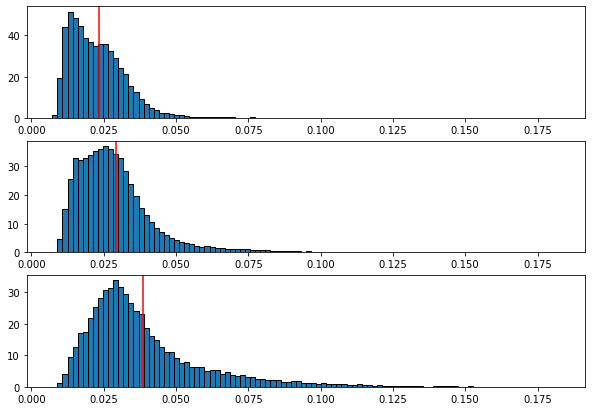

In [72]:
one_inds = meta_df[meta_df["pick_quality"] == 1].index
print(len(one_inds))

two_inds = meta_df[meta_df["pick_quality"] == 0.75].index
print(len(two_inds))

three_inds = meta_df[meta_df["pick_quality"] == 0.5].index
print(len(three_inds))
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
bins = axes[0].hist(trimmed_std[one_inds], density=True, bins=100, edgecolor="k");
bins2 = axes[1].hist(trimmed_std[two_inds], density=True, bins=bins[1], edgecolor="k");
bins3 = axes[2].hist(trimmed_std[three_inds], density=True, bins=bins[1], edgecolor="k");
axes[0].axvline(np.mean(trimmed_std[one_inds]), color="red");
axes[1].axvline(np.mean(trimmed_std[two_inds]), color="red");
axes[2].axvline(np.mean(trimmed_std[three_inds]), color="red");

    

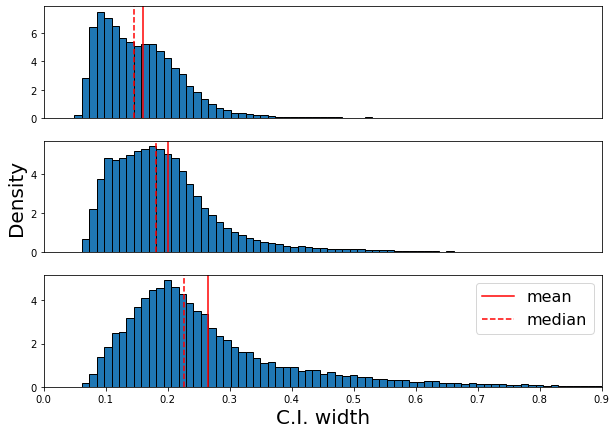

In [69]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
bins = axes[0].hist(widths[one_inds], density=True, bins=100, edgecolor="k");
bins2 = axes[1].hist(widths[two_inds], density=True, bins=bins[1], edgecolor="k");
bins3 = axes[2].hist(widths[three_inds], density=True, bins=bins[1], edgecolor="k");

axes[0].axvline(np.mean(widths[one_inds]), color="red");
axes[1].axvline(np.mean(widths[two_inds]), color="red");
axes[2].axvline(np.mean(widths[three_inds]), color="red", label="mean");

axes[0].axvline(np.median(widths[one_inds]), color="red", linestyle="--");
axes[1].axvline(np.median(widths[two_inds]), color="red", linestyle="--");
axes[2].axvline(np.median(widths[three_inds]), color="red", linestyle="--", label="median");

axes[2].set_xlabel("C.I. width", fontsize=20)
axes[1].set_ylabel("Density", fontsize=20)
axes[2].legend(fontsize=16)
for ax in range(3):
    axes[ax].set_xlim([0, 0.9])
    
axes[0].set_xticks([]);
axes[1].set_xticks([]);

In [24]:
((combined_df["y_act"] > combined_df["lb_y"]) & (combined_df["y_act"] < combined_df["ub_y"])).sum()/len(combined_df)

0.8916101419167521

In [47]:
combined_df

,y_pred,std,lb_y,ub_y,y_act
0,0.293970,0.017291,0.231616,0.349961,0.32
1,0.192086,0.011145,0.151894,0.228177,0.20
2,0.427116,0.024660,0.338185,0.506971,0.43
3,0.475283,0.034338,0.351453,0.586476,0.45
4,0.134654,0.019223,0.065330,0.196903,0.18
...,...,...,...,...,...
79901,0.144764,0.030574,0.034507,0.243770,0.11
79902,0.221248,0.028665,0.117874,0.314073,0.32
79903,0.382591,0.020280,0.309455,0.448263,0.40
79904,0.420219,0.034066,0.297367,0.530534,0.46


In [23]:
((combined_df["y_act"] > (combined_df["y_pred"])-combined_df["std"]) & (combined_df["y_act"] < (combined_df["y_pred"])+combined_df["std"])).sum()/len(combined_df)

0.47330613470828226

In [73]:
np.mean(widths)

0.19713501424322816

In [74]:
np.median(widths)

0.17566083483900607